In [3]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, \
    Conv2D, \
    MaxPooling2D, \
    Flatten, \
    BatchNormalization, \
    Dropout,\
    Rescaling
# from keras.preprocessing import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-02-21 02:02:54.613759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 02:02:54.613851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 02:02:54.796694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
img_height = 256
img_width = 256
batch_size = 32

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels='inferred',
    label_mode='int', # Cats and dogs will get their own integer labels
    batch_size=batch_size,
    image_size=(img_height,img_width)
)
# /kaggle/input/dogs-vs-cats/test
validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/test',
    labels='inferred',
    label_mode='int', # Cats and dogs will get their own integer labels
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches//5)
val_ds = validation_ds.skip(val_batches//5)

In [7]:
print(f'No. of validation batches = {tf.data.experimental.cardinality(val_ds)}')
print(f'No. of validation batches = {tf.data.experimental.cardinality(test_ds)}')

No. of validation batches = 126
No. of validation batches = 31


In [8]:
class_names = train_ds.class_names

In [9]:
class_names

['cats', 'dogs']

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


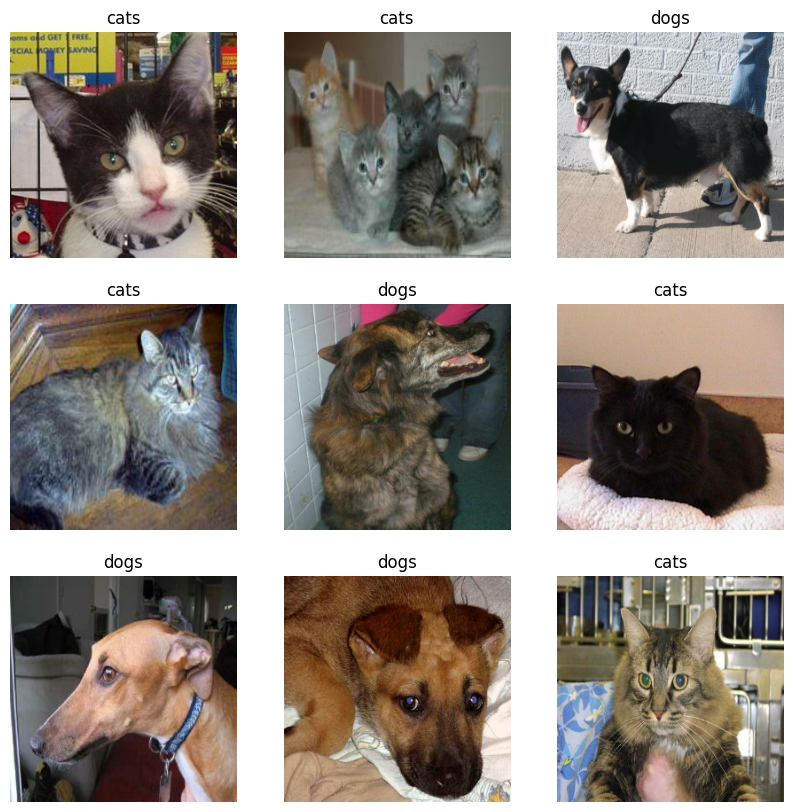

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255, offset=-1)
])

In [14]:
for images, _ in train_ds.take(1):
    for i in range(2):
        img = resize_and_rescale(images[i])
        print(img)
    break

tf.Tensor(
[[[-0.49513185 -0.5500338  -0.70297503]
  [-0.47107285 -0.5259748  -0.67124134]
  [-0.44953275 -0.5093826  -0.64705884]
  ...
  [-0.41637558 -0.439905   -0.5261795 ]
  [-0.4034369  -0.4269663  -0.5132408 ]
  [-0.3967141  -0.42024356 -0.506518  ]]

 [[-0.4834078  -0.53830975 -0.6912509 ]
  [-0.46796584 -0.5228678  -0.6681344 ]
  [-0.44876897 -0.5086189  -0.6462951 ]
  ...
  [-0.60848373 -0.6320132  -0.7182877 ]
  [-0.600493   -0.6240224  -0.7102969 ]
  [-0.6023667  -0.6258961  -0.7121706 ]]

 [[-0.47228855 -0.52719057 -0.68013173]
  [-0.46289337 -0.5177953  -0.66306186]
  [-0.44578588 -0.50563574 -0.6433119 ]
  ...
  [-0.6130546  -0.636584   -0.7228585 ]
  [-0.6176547  -0.6411841  -0.7274586 ]
  [-0.62476933 -0.64829874 -0.73457325]]

 ...

 [[-0.38526523 -0.38040155 -0.44126248]
  [-0.39685196 -0.39198834 -0.4528492 ]
  [-0.39207256 -0.38720894 -0.4480698 ]
  ...
  [-0.42148745 -0.42148745 -0.5234482 ]
  [-0.41662836 -0.41662836 -0.51858914]
  [-0.41726315 -0.41726315 -0.519

In [15]:
IMG_SHAPE = (img_height, img_width) + (3,)
IMG_SHAPE

(256, 256, 3)

In [16]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

print(f'Our final feature map is: {feature_batch.shape}')


Our final feature map is: (32, 8, 8, 1280)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

In [21]:
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [22]:
# Define the input layer with the shape of your images
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Apply data augmentation
x = data_augmentation(inputs)

# Apply resize and rescale operations
x = resize_and_rescale(x)

# Pass the data through the base model
x = base_model(x, training=False)

# Apply global average pooling to flatten the output of the base model
x = global_average_layer(x)

# Add a new dense layer with 1280 units and ReLU activation
x = tf.keras.layers.Dense(1280, activation='relu')(x)

# Add another dense layer with 512 units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add another dropout layer
x = tf.keras.layers.Dropout(0.1)(x)  # Dropout rate of 10%

# Add the final prediction layer
outputs = tf.keras.layers.Dense(1)(x)  # Single neuron for output

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Now you can see the summary of your model
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1280)              163968

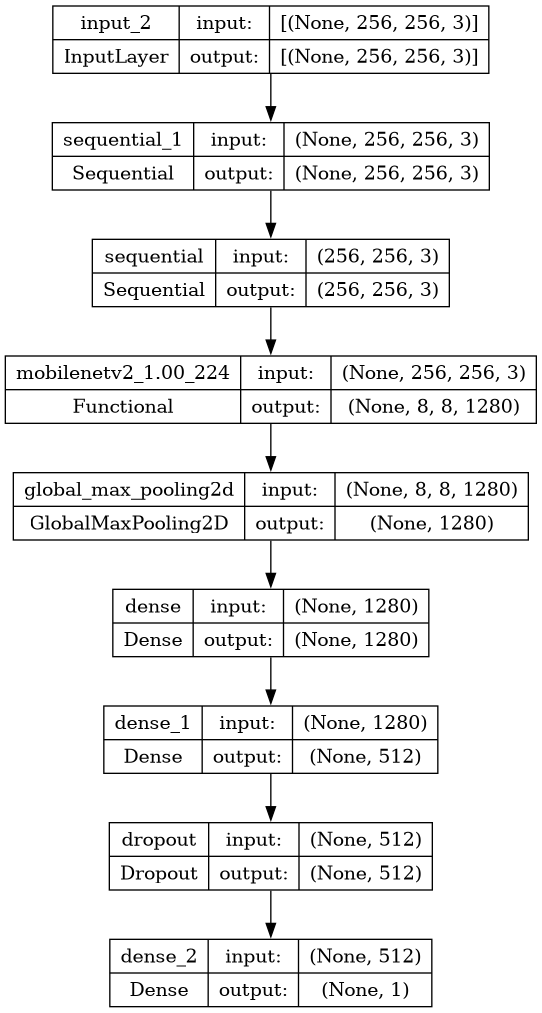

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

126/126 [==============================] - 13s 66ms/step - loss: 0.8042 - accuracy: 0.5741


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)

In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.80
initial accuracy: 0.57


In [28]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1708481040.702352     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 51s 72ms/step - loss: 0.1054 - accuracy: 0.9628 - val_loss: 0.0473 - val_accuracy: 0.9843
Epoch 2/10
625/625 [==============================] - 43s 68ms/step - loss: 0.0708 - accuracy: 0.9724 - val_loss: 0.0428 - val_accuracy: 0.9843
Epoch 3/10
625/625 [==============================] - 42s 68ms/step - loss: 0.0681 - accuracy: 0.9732 - val_loss: 0.0552 - val_accuracy: 0.9820
Epoch 4/10
625/625 [==============================] - 43s 68ms/step - loss: 0.0599 - accuracy: 0.9762 - val_loss: 0.0386 - val_accuracy: 0.9853
Epoch 5/10
625/625 [==============================] - 43s 68ms/step - loss: 0.0574 - accuracy: 0.9772 - val_loss: 0.0472 - val_accuracy: 0.9835
Epoch 6/10
625/625 [==============================] - 42s 68ms/step - loss: 0.0559 - accuracy: 0.9783 - val_loss: 0.0382 - val_accuracy: 0.9868
Epoch 7/10
625/625 [==============================] - 42s 68ms/step - loss: 0.0518 - accuracy: 0.9811 - val_loss: 0.0386 - val_accuracy: 0.9878
Epo

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


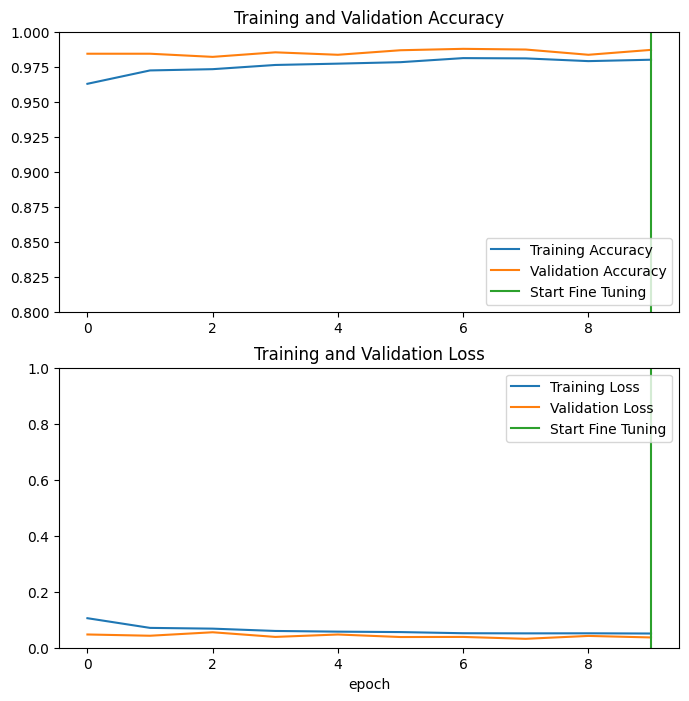

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [31]:
base_model.trainable = True


In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])


In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)


model_checkpoint = ModelCheckpoint(
    'path/to/save/model.{epoch:02d}-{val_loss:.2f}.h5',  
    save_best_only=True,                                 
    monitor='val_loss',                                  
    mode='min',                                          
    verbose=1)   

callbacks_list = [early_stopping, model_checkpoint]

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds, callbacks=callbacks_list)


Epoch 10/20
625/625 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9834
Epoch 10: val_loss improved from inf to 0.03480, saving model to path/to/save/model.10-0.03.h5
625/625 [==============================] - 59s 82ms/step - loss: 0.0451 - accuracy: 0.9834 - val_loss: 0.0348 - val_accuracy: 0.9883
Epoch 11/20
625/625 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9843
Epoch 11: val_loss improved from 0.03480 to 0.03114, saving model to path/to/save/model.11-0.03.h5
625/625 [==============================] - 50s 79ms/step - loss: 0.0413 - accuracy: 0.9843 - val_loss: 0.0311 - val_accuracy: 0.9888
Epoch 12/20
625/625 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9866
Epoch 12: val_loss improved from 0.03114 to 0.02894, saving model to path/to/save/model.12-0.03.h5
625/625 [==============================] - 50s 80ms/step - loss: 0.0367 - accuracy: 0.9866 - val_loss: 0.0289 - val_accuracy: 0.9885
Epoch 13/20
625/6

In [40]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

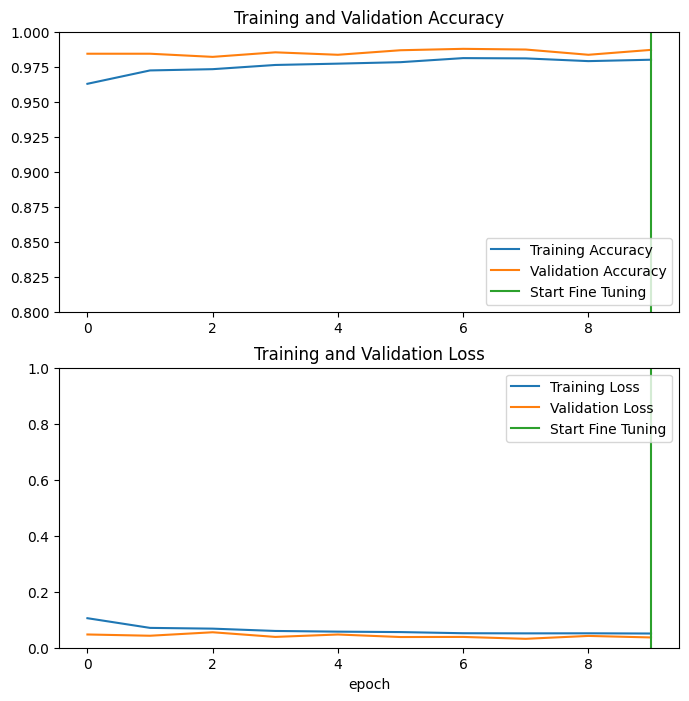

31/31 [==============================] - 2s 53ms/step - loss: 0.0484 - accuracy: 0.9808
Test accuracy : 0.9808467626571655


In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)


In [44]:
loss, accuracy = model.evaluate(test_ds)
print("-"*60)
print('Test accuracy :', accuracy)



31/31 [==============================] - 2s 53ms/step - loss: 0.0480 - accuracy: 0.9829
------------------------------------------------------------
Test accuracy : 0.9828628897666931


Predictions:
 [0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1]
Labels:
 [0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1]


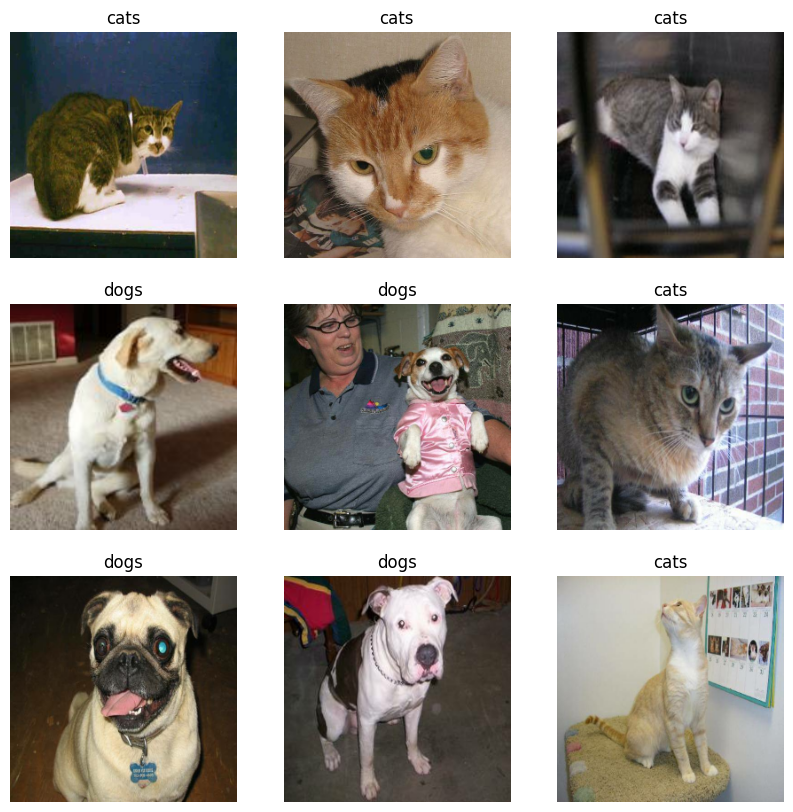

In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
